# Encoder-Decoder vs nn.Transformer Testing

### Create Dataloaders

In [ ]:
# %load_ext autoreload
# %autoreload 2

# import sys
# sys.path.append("..")

# from basic_transformer import TransformerEncDec
# from basic_tokenizers import ByteTextTokenizer
# from helpers import total_params

# from fastai.text.all import *
# from fastai.basics import *

No module named 'axial_positional_embedding'


In [ ]:
import torch

from fastai.text.all import *
from fastai.basics import *

from reformer_fastai.reformer import ReformerLM
from reformer_fastai.transformer import TransformerLM

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
path = Path('..')
df = pd.read_csv(path/'en_ga_prep.csv', index_col=0)
df.head()

,clean,en,en_len,ga,ga_len
0,True,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .",18,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
1,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",18
2,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
3,True,"As you can see, so get to show off the spacious shapes in 3D (red and blue).",17,"Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",21
4,True,"Equation Solving – Traditional, simple",5,"Ligningsløsning – Traidisiúnta, simplí",4


In [ ]:
#df = df[:32]

def add_eos(text):
    return text + f' {EOS}'

dblock = DataBlock(blocks=(TextBlock.from_df('en', tok_text_col='en', rules=[add_eos]),
                           TextBlock.from_df('ga', tok_text_col='ga', rules=[add_eos])),
                   get_x=ColReader('en'),
                   get_y=ColReader('ga'), 
                   splitter=RandomSplitter())

dsets = dblock.datasets(df)

pad_seq2seq = partial(pad_input, pad_fields=[0,1])

dls = dsets.dataloaders(bs=16, dl_type=SortedDL, before_batch=pad_seq2seq)
dls.show_batch(max_n=4)

/home/morgan/anaconda3/envs/fastai_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"( a ) any business other than the sale of intoxicating liquor ( in this section referred to as non - licensed business ) is carried on in any premises to which an on - licence or an off - licence is attached ( other than premises to which a wine retailer 's off - licence within the meaning of the Finance ( 1909 - 10 ) Act , 1910 , and no other off - licence is attached ) , and xxeos","( a ) aon ghnó seachas díol deochanna meisciúla ( dá ngairtear gnó neamhcheadúnaithe san alt seo ) a bheith ar siúl in aon áitreabh lena ngabhann ar - cheadúnas nó eis - cheadúnas ( seachas áitreabh a ngabhann eis - cheadúnas miondíoltóra fíona de réir bhrí an Finance ( 1909 - 10 ) Act , 1910 , agus nach ngabhann aon eis - cheadúnas eile , leis ) , agus xxeos xxpad xxpad xxpad xxpad xxpad"
1,"( 3 ) The several statutory and other provisions which were in force on the 5th day of April , 1947 , in relation to income tax and sur - tax shall , subject to the provisions of this Act , have effect in relation to the income tax and sur - tax to be charged as aforesaid for the year beginning on the 6th day of April , 1947 . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( 3 ) Na forála , reachtúla agus eile , a bhí i bhfeidhm an 5ú lá d'Aibreán , 1947 , maidir le cáin ioncaim agus forcháin , beidh éifeacht acu uile agus faoi seach , faoi réir forál an Achta seo , maidir leis an gcáin ioncaim agus an fhorcháin a muirearófar mar adúradh in aghaidh na bliana dar tosach an 6ú lá d'Aibreán , 1947 . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
2,"( 2 ) In section 241 ( 6 ) of the Income Tax Act , 1967 , “ the deductions on that account , and ” , and the expression “ the deductions ” where that expression occurs before “ and allowances ” , shall each be construed as not including a reference to any investment allowance made to the person by whom the trade or profession is carried on . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( 2 ) In alt 241 ( 6 ) den Acht Cánach Ioncaim , 1967 , déanfar an abairt “ na hasbhaintí mar gheall air sin , agus ” an abairt “ na n - asbhaintí ” mar a bhfuil an abairt sin roimh “ agus na liúntas ” a fhorléiriú , gach abairt acu , mar abairt nach bhfolaíonn tagairt d'aon liúntas infheistíochta a thugtar do dhuine a sheolann an trádáil nó an ghairm . xxeos"
3,"( i ) has indicated to the Court that he wishes to have in the hotel a public bar for the sale of intoxicating liquor and has shown , to the satisfaction of the Court , in relation to an ordinary seven - day licence ( not being a licence granted by virtue of paragraph ( 2 ) of section 2 of the Act of 1902 ) , either— xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( i ) a chur in iúl don Chúirt gur mian leis beár poiblí a bheith aige san óstán chun deochanna meisciúla a dhíol , agus a chruthú don Chúirt , maidir le gnáthcheadúnas seacht lá ( nach ceadúnas a deonaíodh de bhua mhír ( 2 ) d'alt 2 d'Acht xxunk xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"


In [ ]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def before_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS when it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def before_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

In [ ]:
en_vocab_sz = len(dls.vocab[0])
ga_vocab_sz = len(dls.vocab[1])
d_model = 768
d_ff = 2048

xb, yb = dls.one_batch()
xb.shape, yb.shape

((16, 83), (16, 76))

In [ ]:
# import pickle
# def save_obj(obj, name ):
#     with open(name + '.pkl', 'wb') as f:
#         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

# def load_obj(name ):
#     with open(name + '.pkl', 'rb') as f:
#         return pickle.load(f)

# Start Testing

## Standard Attention

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'atd_attn_match_pt_q_scaling_enc_causal_no_pad_mask_zero_drop'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention to match PT model; with MHA q-scaling, encoder causal masking, no padding masking, zero dropout'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

# Xavier Uniform
from torch.nn.init import xavier_uniform_
for p in enc_dec_model.parameters():
    if p.dim() > 1:
        xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

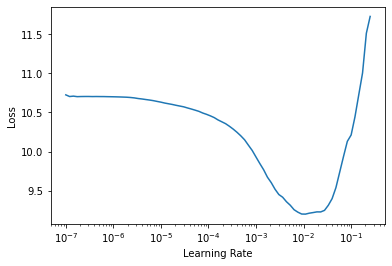

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00065, 0.00583)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.157176    2.154791    0.504697  0.319441     32:17     
1         1.487250    1.486754    0.575191  0.415881     36:42     
2         1.130419    1.286710    0.599631  0.452224     33:53     


In [ ]:
arto_encdec_learn.recorder.final_record

(#4) [1.1304188966751099,1.2867099046707153,0.5996313095092773,0.45222358689086267]

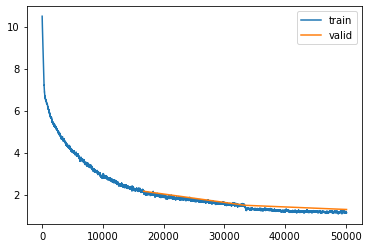

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, no enc masking, no pad masking, zero dropout

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'atd_attn_no_enc_mask_q_scaling_enc_causal_no_pad_mask_zero_drop'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention with no encoder causal masking, with MHA q-scaling, no padding masking, zero dropout'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

# Xavier Uniform
from torch.nn.init import xavier_uniform_
for p in enc_dec_model.parameters():
    if p.dim() > 1:
        xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.2089296132326126)

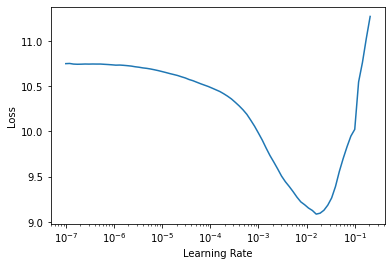

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00065, 0.00583)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.287649    2.281429    0.489051  0.298027     32:05     
1         1.513167    1.500189    0.573884  0.413130     32:30     
2         1.167364    1.291389    0.599324  0.451910     32:35     


In [ ]:
arto_encdec_learn.recorder.final_record

(#4) [1.1673636436462402,1.291388750076294,0.5993238687515259,0.4519100083881804]

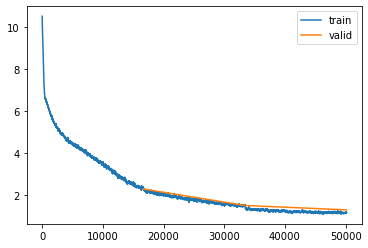

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, no enc masking, no pad masking, with dropout

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'atd_attn_with_drop_no_enc_mask_q_scaling_no_pad_mask'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention with dropout, no encoder causal masking, with MHA q-scaling, no padding masking'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

# Xavier Uniform
from torch.nn.init import xavier_uniform_
for p in enc_dec_model.parameters():
    if p.dim() > 1:
        xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

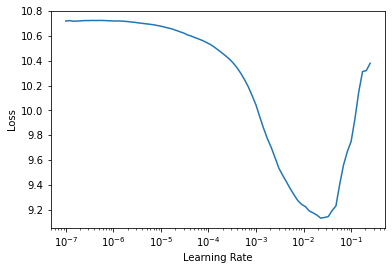

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00065, 0.00583)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.463661    3.357221    0.355376  0.158983     32:42     
1         2.280187    2.156690    0.497536  0.308558     33:08     
2         1.989430    24:50       


KeyboardInterrupt: 

In [ ]:
arto_encdec_learn.recorder.final_record

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, no enc masking, with pad masking, with dropout

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_no_enc_mask_with_drop_with_pad_mask'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention with dropout and pad masking, no encoder causal masking, q-scaling'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

# Xavier Uniform
from torch.nn.init import xavier_uniform_
for p in enc_dec_model.parameters():
    if p.dim() > 1:
        xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

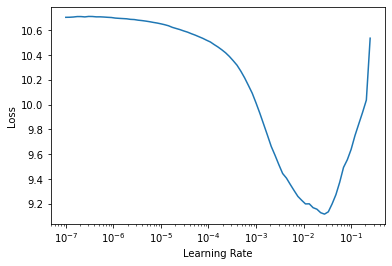

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00065, 0.00583)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.278603    3.210866    0.373155  0.173626     34:58     
1         2.785632    12:25       


KeyboardInterrupt: 

In [ ]:
arto_encdec_learn.recorder.final_record

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, no enc masking, with pad masking, with dropout except attn dropout

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn_no_enc_mask_no_attn_drop_with_pad_mask'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention no attn dropout, with emb and FF dropout and pad masking, no encoder causal masking, q-scaling'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

# Xavier Uniform
from torch.nn.init import xavier_uniform_
for p in enc_dec_model.parameters():
    if p.dim() > 1:
        xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

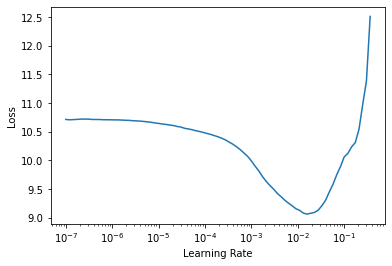

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00065, 0.00583)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, div=5, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.681746    2.588972    0.450937  0.253564     34:11     
1         1.646254    1.623643    0.558704  0.390274     35:01     
2         1.391245    1.420781    0.583184  0.427551     35:29     


In [ ]:
arto_encdec_learn.recorder.final_record

(#4) [1.3912454843521118,1.4207806587219238,0.5831839442253113,0.4275509707773419]

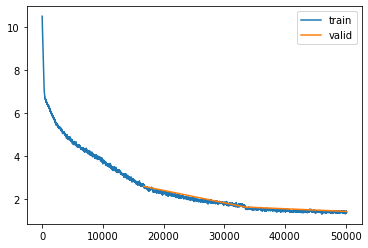

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, replicate Arto best (std_attn+q_scale) - no enc masking, with pad masking

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn+q_scale_replicate'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, q-scaling, d_ff 3072 (dim*4), zero dropout, with padding masking, div=25'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed', d_ff=None, comb_attn=False)

# # Xavier Uniform
# from torch.nn.init import xavier_uniform_
# for p in enc_dec_model.parameters():
#     if p.dim() > 1:
#         xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

157057528

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

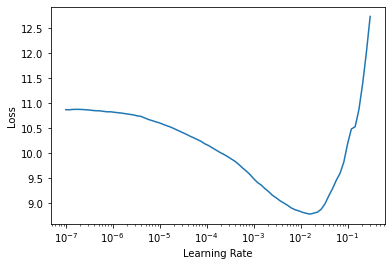

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00063, 0.00585)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.232948    2.253576    0.486032  0.295794     33:56     
1         1.359753    1.422024    0.578695  0.420378     34:26     
2         1.023112    1.219540    0.603724  0.460160     34:45     


In [ ]:
arto_encdec_learn.recorder.final_record

No module named 'axial_positional_embedding'


(#4) [1.0231119394302368,1.2195404767990112,0.6037238240242004,0.46016035618536427]

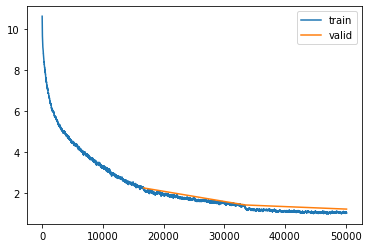

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, (std_attn+q_scale) - with PT Embedding, no enc masking, with pad masking, no dropout 

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn+q_scale_pt_embed'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, with PyTorch embedding, q-scaling, d_ff 3072 (dim*4), zero dropout, with padding masking, div=25'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed', d_ff=None, comb_attn=False)

# # Xavier Uniform
# from torch.nn.init import xavier_uniform_
# for p in enc_dec_model.parameters():
#     if p.dim() > 1:
#         xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

157057528

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

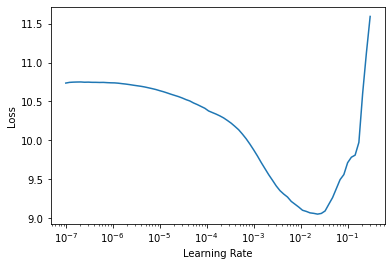

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00063, 0.00585)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.248737    2.232326    0.497073  0.307837     33:54     
1         1.416782    1.454869    0.580143  0.422341     34:21     
2         1.142937    1.250775    0.604129  0.459550     34:36     


In [ ]:
arto_encdec_learn.recorder.final_record

No module named 'axial_positional_embedding'


(#4) [1.1429373025894165,1.250774621963501,0.6041288375854492,0.45955007090956645]

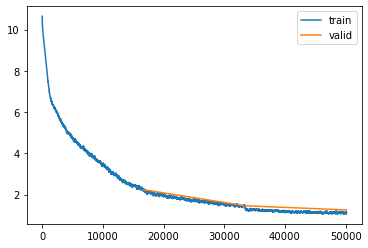

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, (std_attn+q_scale) - FairSeq embed init, BasicTransformer embed, no enc masking, with pad masking, no dropout 

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn+q_scale_fairseq_emb_init'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention,with FairSeq embedding init, q-scaling, d_ff 3072 (dim*4), zero dropout, with padding masking, div=25'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

No module named 'axial_positional_embedding'


In [ ]:
#TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed', d_ff=None, comb_attn=False)

# # Xavier Uniform
# from torch.nn.init import xavier_uniform_
# for p in enc_dec_model.parameters():
#     if p.dim() > 1:
#         xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

157057528

SuggestedLRs(lr_min=0.04365158379077912, lr_steep=0.3630780577659607)

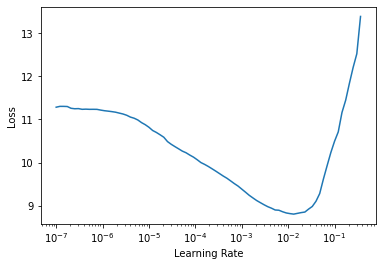

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00063, 0.00585)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.395136    2.347726    0.471264  0.276963     33:53     
1         1.483979    1.473076    0.568607  0.405488     34:10     
2         1.039568    1.250922    0.596546  0.447895     34:11     


In [ ]:
arto_encdec_learn.recorder.final_record

No module named 'axial_positional_embedding'


[autoreload of basic_transformer failed: Traceback (most recent call last):
  File "/home/morgan/anaconda3/envs/fastai_env/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: __init__() requires a code object with 1 free vars, not 0
]


(#4) [1.0395677089691162,1.2509217262268066,0.5965457558631897,0.4478954097725498]

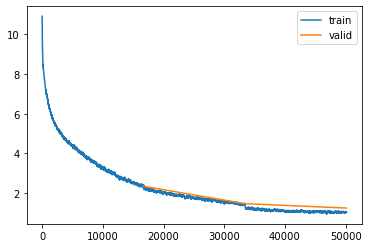

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention, (std_attn+q_scale) - refactoring test, BasicTransformer embed, no enc masking, with pad masking, no dropout 

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'std_attn+q_scale_refactor_test_7'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing if refactoring broke anything, standard attention, q-scaling, d_ff 3072 (dim*4), zero dropout, with padding masking, div=25'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

No module named 'axial_positional_embedding'


In [ ]:
# TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, d_ff=None, 
                  n_enc_layers=6, n_dec_layers=6, heads=8, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed',  max_seq_len=256, comb_attn=False)

# # Xavier Uniform
# from torch.nn.init import xavier_uniform_
# for p in enc_dec_model.parameters():
#     if p.dim() > 1:
#         xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

157057528

SuggestedLRs(lr_min=0.02089296132326126, lr_steep=0.17378008365631104)

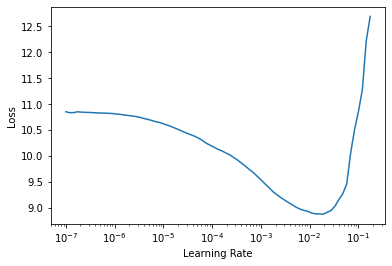

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00063, 0.00585)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.179012    2.243437    0.487839  0.296410     34:11     
1         1.405244    1.417627    0.579063  0.422904     34:39     
2         1.104074    1.221896    0.602997  0.459711     34:52     


In [ ]:
arto_encdec_learn.recorder.final_record

No module named 'axial_positional_embedding'


(#4) [1.104074478149414,1.2218961715698242,0.6029968857765198,0.4597112015324851]

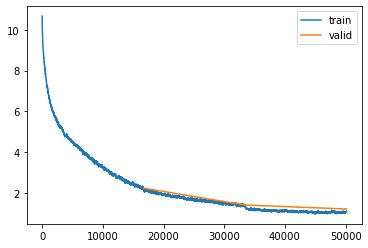

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Comb Attn

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn_q_scale_zero_drop'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Combined attention, q-scaling, d_ff 3072 (dim*4), zero dropout, with padding masking, div=25'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
from basic_transformer import TransformerEncDec
from basic_transformer import *

In [ ]:
# TransformerEncDec??

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, d_ff=None, 
                  n_enc_layers=6, n_dec_layers=6, heads=8, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.0, ff_dropout=0.0, emb_dropout=0.0,
                 pos_enc='fixed',  max_seq_len=256, comb_attn=True)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

142874104

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.12022644281387329)

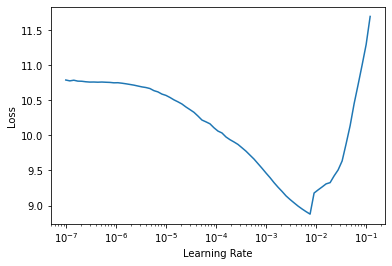

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00064, 0.00583)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 1e-4, cbs=[WandbCallback(log_model=False, log_preds=False)])  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.263201    2.316428    0.479608  0.281611     29:30     
1         1.387569    1.444555    0.577392  0.415898     29:52     
2         1.091472    1.247738    0.601678  0.454726     29:49     


In [ ]:
arto_encdec_learn.recorder.final_record

(#4) [1.0914721488952637,1.2477381229400635,0.6016778945922852,0.45472558534724455]

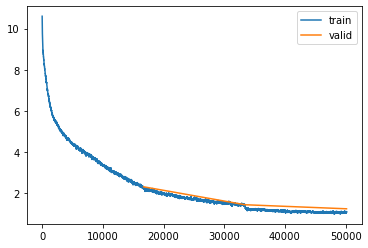

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Higher LR

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'standard_attn_higher_lr_fixed_postLN_xav_uni'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, with higher lr, with fixed PostLN and Xavier Uniform init, scaling Attention with kdim instead of dim, with negative INF masking, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

In [ ]:
# %load_ext autoreload
# %autoreload 2

# from basic_transformer import TransformerEncDec
# from basic_transformer import *

# enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
#                  max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='fixed', d_ff=d_ff, comb_attn=False)

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

# Xavier Uniform
from torch.nn.init import xavier_uniform_

for p in enc_dec_model.parameters():
    if p.dim() > 1:
        xavier_uniform_(p)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

In [ ]:
arto_encdec_learn.fit_one_cycle(3, 4e-3, div=5, WandbCallback(log_model=False, log_preds=False))  

In [ ]:
arto_encdec_learn.recorder.final_record

In [ ]:
arto_encdec_learn.recorder.plot_loss()

## Standard Attention Test - Output Monitoring

In [ ]:
# from basic_transformer import *

# class TransformerEncDec(nn.Module):
#     def __init__(self, enc_vocab_sz, dec_vocab_sz, dim, depth=6, heads=8, 
#                  max_seq_len=512, pad_idx=None, tie_weights=True, 
#                  attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
#                  pos_enc='absolute', d_ff=None, prenorm=False, 
#                  axial_shape=None, axial_emb_dims=None,
#                  comb_attn=False, attn_bias=True):
#         super().__init__()
#         self.max_seq_len = max_seq_len
#         self.depth = depth
#         self.pad_idx = pad_idx
#         self.enc_emb = TransformerEmbedding(enc_vocab_sz, dim, max_seq_len, dropout=emb_dropout, pos_enc=pos_enc,
#                                             axial_shape=axial_shape, axial_emb_dims=axial_emb_dims)
#         self.dec_emb = TransformerEmbedding(dec_vocab_sz, dim, max_seq_len, dropout=emb_dropout, pos_enc=pos_enc,
#                                             axial_shape=axial_shape, axial_emb_dims=axial_emb_dims)
#         self.encoder = TransformerEncoder(dim, depth, heads, d_ff=d_ff, attn_dropout=attn_dropout, ff_dropout=ff_dropout, 
#                                           prenorm=prenorm, attn_bias=attn_bias, final_norm=nn.LayerNorm)
#         self.decoder = TransformerDecoder(dim, depth, heads, d_ff=d_ff, attn_dropout=attn_dropout, ff_dropout=ff_dropout, 
#                                           prenorm=prenorm, comb_attn=comb_attn, attn_bias=attn_bias, final_norm=nn.LayerNorm)
#         self.proj = nn.Linear(dim, dec_vocab_sz)
#         if tie_weights: self.proj.weight = self.dec_emb.emb.weight
            
#         self.monitor = {}
#         self.log_step = 0

#     def forward(self, src, tgt, src_mask = None, tgt_mask = None):
#         src_mask = default(src_mask, self.get_padding_mask(src))
#         tgt_mask = default(tgt_mask, self.get_padding_mask(tgt))
        
#         enc_emb_t = self.enc_emb(src)
#         self.log_act_stats('enc_emb', enc_emb_t)
    
#         dec_emb_t = self.dec_emb(tgt)
#         self.log_act_stats('dec_emb', enc_emb_t)
    
#         enc = self.encoder(enc_emb_t, mask = src_mask)
#         self.log_act_stats('enc_out', enc)
        
#         out = self.decoder(dec_emb_t, context=enc, mask=tgt_mask, context_mask=src_mask)
#         self.log_act_stats('dec_out', out)
        
#         fin_out = self.proj(out)
#         self.log_act_stats('fin_out', fin_out)
#         self.log_step += 1
        
#         return fin_out

#     def get_padding_mask(self, x):
#         if self.pad_idx is None: return None
#         return (x != self.pad_idx)
    
#     def log_act_stats(self, nm, x):
#         if self.log_step == 0:
#             self.monitor[f'{nm}_mean'] = [x.mean().item()]
#             self.monitor[f'{nm}_std'] = [x.std().item()]
#             self.monitor[f'{nm}_pct_zero'] = [(x<=0.05).long().sum().item()/x.numel()]
#         else:
#             self.monitor[f'{nm}_mean'].append(x.mean().item())
#             self.monitor[f'{nm}_std'].append(x.std().item())
#             self.monitor[f'{nm}_pct_zero'].append((x<=0.05).long().sum().item()/x.numel())

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'standard_attn_monitor'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Standard attention, scaling Attention with kdim instead of dim, with negative INF masking, FF layer size 2048, with LNs at top of Encoder and Decoder, with Xavier attn init, attn bias and fixed positional encodings'
CONFIG = {}
TAGS =['std_attn','enc_dec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='fixed', d_ff=d_ff, comb_attn=False)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(arto_encdec_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.02290867641568184)

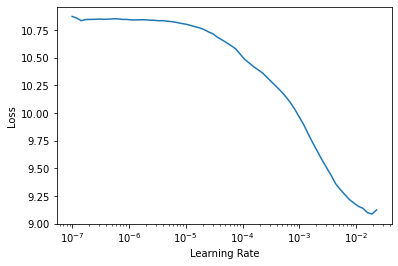

In [ ]:
arto_encdec_learn.lr_find()

In [ ]:
N=0
N += total_params(enc_dec_model.encoder)[0]
N += total_params(enc_dec_model.decoder)[0]
N += total_params(enc_dec_model.proj)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00065, 0.00583)

In [ ]:
arto_encdec_learn.fit_one_cycle(1, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         3.170603    3.105767    0.401135  0.198291     35:14     


In [ ]:
arto_encdec_learn.recorder.final_record

(#4) [3.1706032752990723,3.105766534805298,0.40113499760627747,0.19829148408919553]

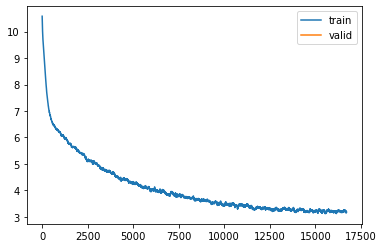

In [ ]:
arto_encdec_learn.recorder.plot_loss()

In [ ]:
save_obj(arto_encdec_learn.model.monitor, 'enc_dec_monitor')

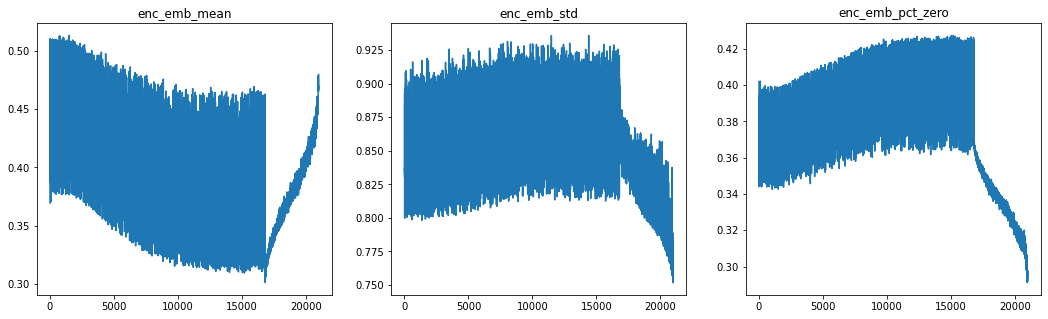

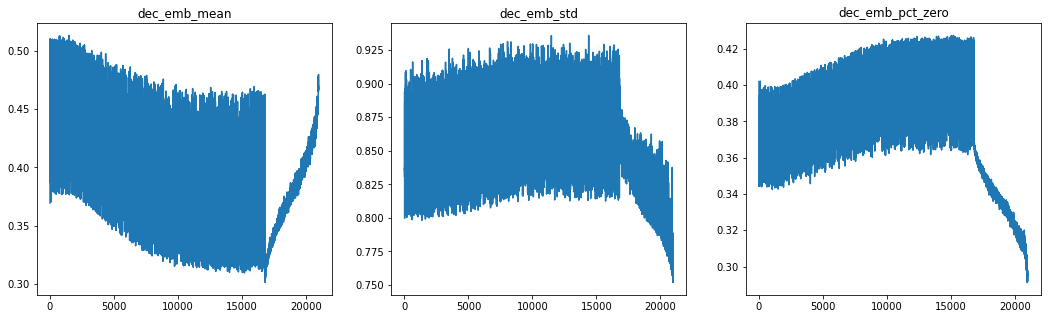

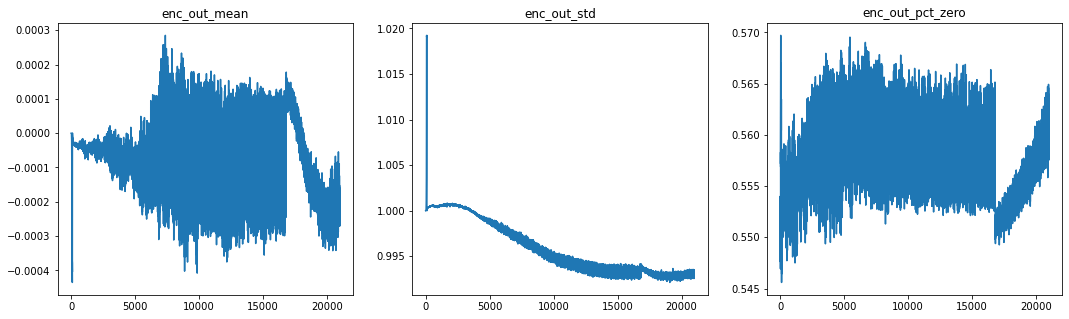

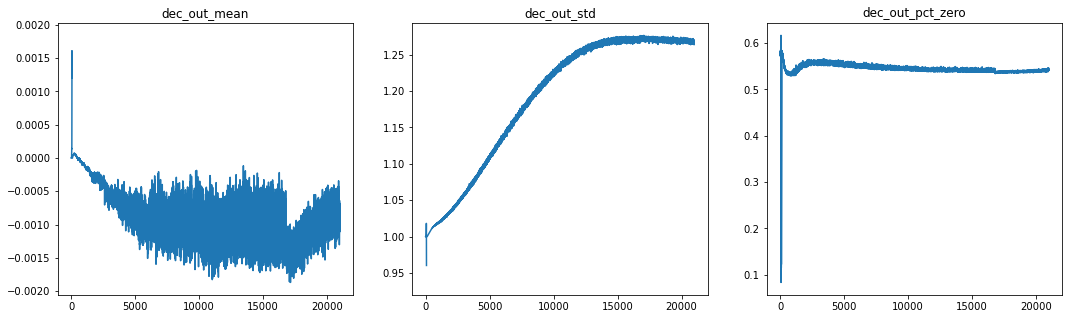

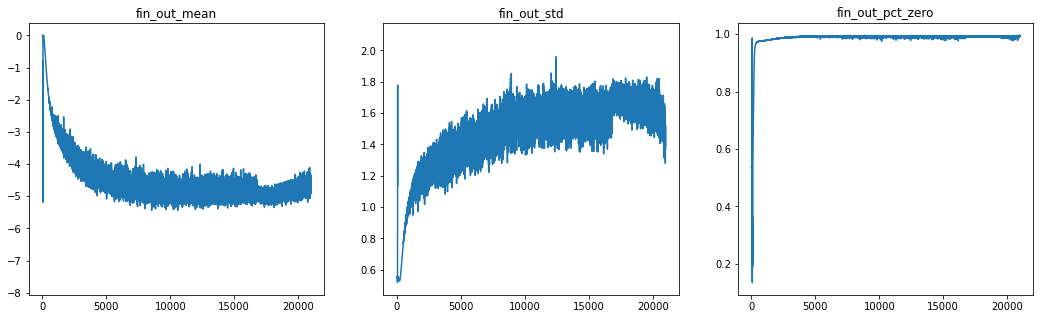

In [ ]:
enc_dec_dict = load_obj('enc_dec_monitor')

n_stats = len(list(end_dec_dict.keys())) 

for i in range(0, int(n_stats), 3):
    _,axs = subplots(1, 3, figsize=(18,5))
    ks = list(end_dec_dict.keys())[i:i+3]
    for o,ax,title in zip(ks,axs,(ks[0], ks[1], ks[2])):
        ax.plot(end_dec_dict[o])
        ax.set_title(title)

### PyTorch Transformer Monitor

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'pt_encdec_1ep_monitor'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'pytorch nn.Transformer 1 epoch logging output stats'
CONFIG = {}
TAGS =['pt_encdec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

    
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [ ]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, # d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True, activation='gelu'):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16

        self.final.weight = self.dec_tfmr_emb.embed.weight    # Tie Weights
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation=activation, custom_encoder=None, custom_decoder=None)
        
        self.monitor = {}
        self.log_step = 0
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        # Test whether fp16 is being used or not
        if not isinstance(self.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
                          torch.cuda.FloatTensor):
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        self.log_act_stats('enc_emb', enc_emb)
        self.log_act_stats('dec_emb', dec_emb)
        
        src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                                         src_key_padding_mask=None, tgt_key_padding_mask=None, 
                                         memory_key_padding_mask=None)
        self.log_act_stats('dec_out', dec_out.permute(1,0,2))
        
        out=self.final(dec_out)
        
        self.log_act_stats('final', dec_out.permute(1,0,2))
        self.log_step += 1
            
        return out.permute(1,0,2)
    
    def log_act_stats(self, nm, x):
        if self.log_step == 0:
            self.monitor[f'{nm}_mean'] = [x.mean().item()]
            self.monitor[f'{nm}_std'] = [x.std().item()]
            self.monitor[f'{nm}_pct_zero'] = [(x<=0.05).long().sum().item()/x.numel()]
        else:
            self.monitor[f'{nm}_mean'].append(x.mean().item())
            self.monitor[f'{nm}_std'].append(x.std().item())
            self.monitor[f'{nm}_pct_zero'].append((x<=0.05).long().sum().item()/x.numel())


In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

pt_model = pt_Transformer(src_vcbsz=en_vocab_sz, trg_vcbsz=ga_vocab_sz, d_model=d_model, d_inner=d_ff)

pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(pt_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

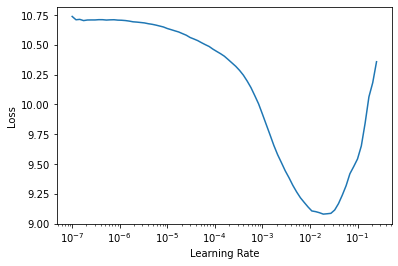

In [ ]:
pt_learn.lr_find()

In [ ]:
N=0
N += total_params(pt_model.transformer_model)[0]
N += total_params(pt_model.final)[0]

round(0.003239 - 0.0001395 * np.log(N), 5), round(0.003239 + 0.0001395 * np.log(N), 5)

(0.00065, 0.00583)

In [ ]:
pt_learn.fit_one_cycle(1, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.485342    2.361239    0.488268  0.296306     29:12     


In [ ]:
pt_learn.recorder.final_record

(#4) [2.485342025756836,2.361239433288574,0.4882679581642151,0.29630551142650474]

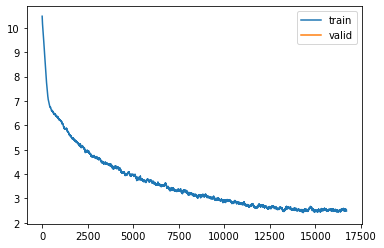

In [ ]:
pt_learn.recorder.plot_loss()

In [ ]:
save_obj(pt_learn.model.monitor, 'pt_monitor')

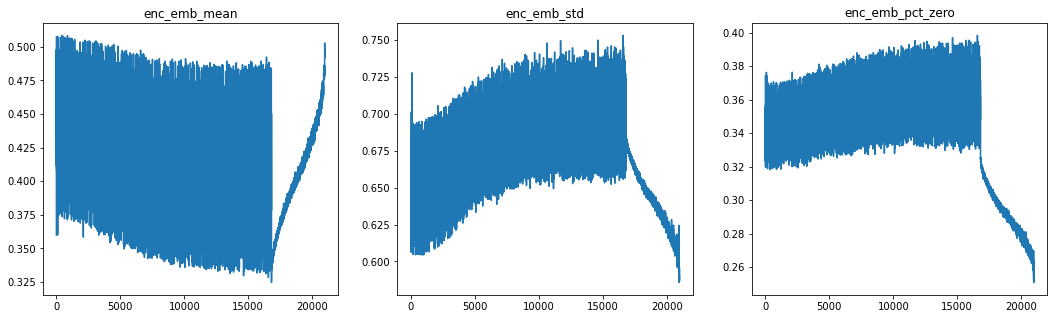

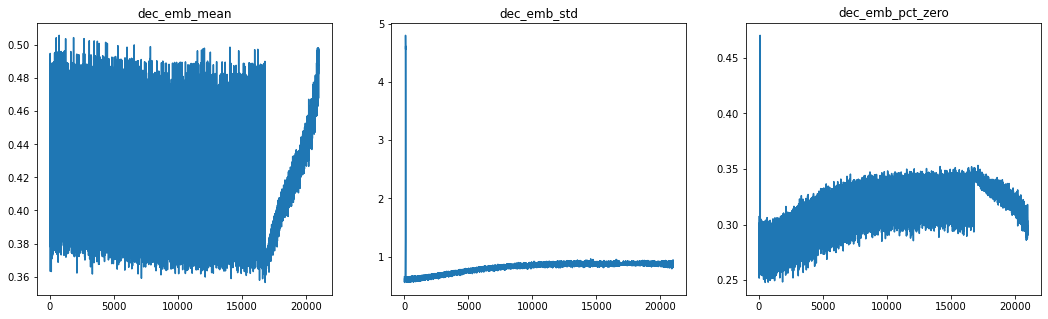

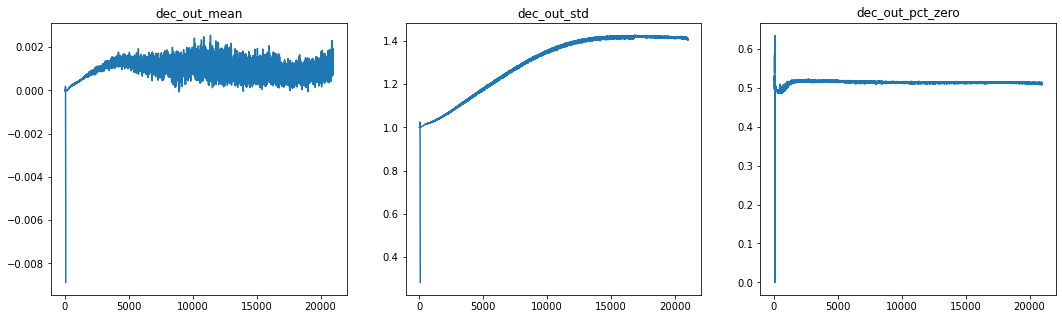

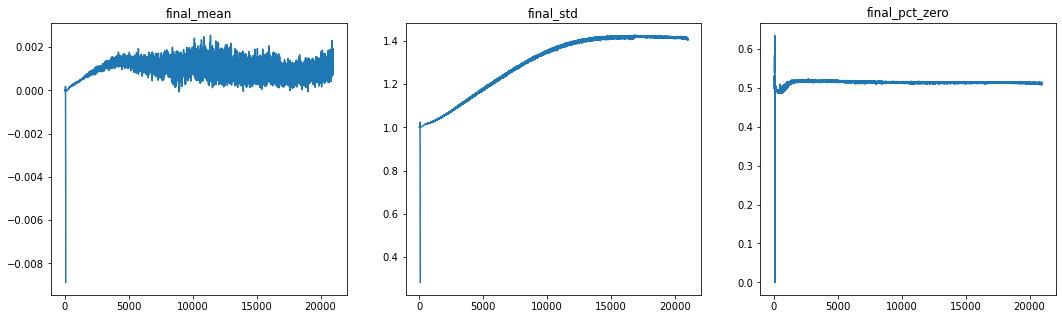

In [ ]:
pt_dict = load_obj('pt_monitor')

n_stats = len(list(pt_dict.keys())) 

for i in range(0, int(n_stats), 3):
    _,axs = subplots(1, 3, figsize=(18,5))
    ks = list(pt_dict.keys())[i:i+3]
    for o,ax,title in zip(ks,axs,(ks[0], ks[1], ks[2])):
        ax.plot(pt_dict[o])
        ax.set_title(title)

# Compare Both

In [ ]:
pt_dict = load_obj('pt_monitor')
enc_dec_dict = load_obj('enc_dec_monitor')

In [ ]:
pt_dict.keys()

dict_keys(['enc_emb_mean', 'enc_emb_std', 'enc_emb_pct_zero', 'dec_emb_mean', 'dec_emb_std', 'dec_emb_pct_zero', 'dec_out_mean', 'dec_out_std', 'dec_out_pct_zero', 'final_mean', 'final_std', 'final_pct_zero'])

### Encoder Embedding

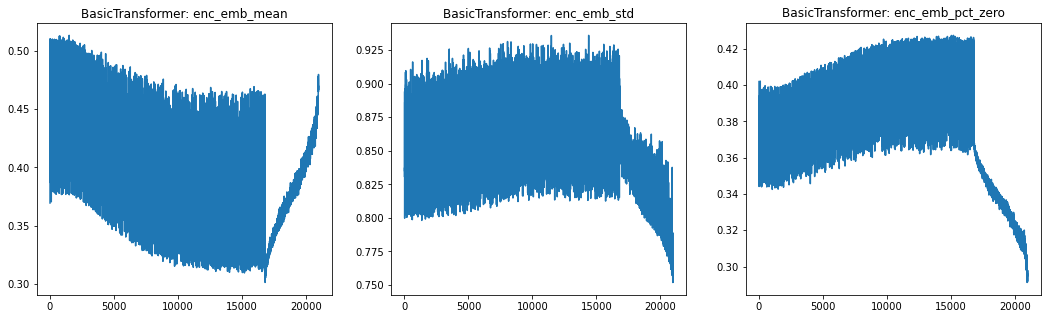

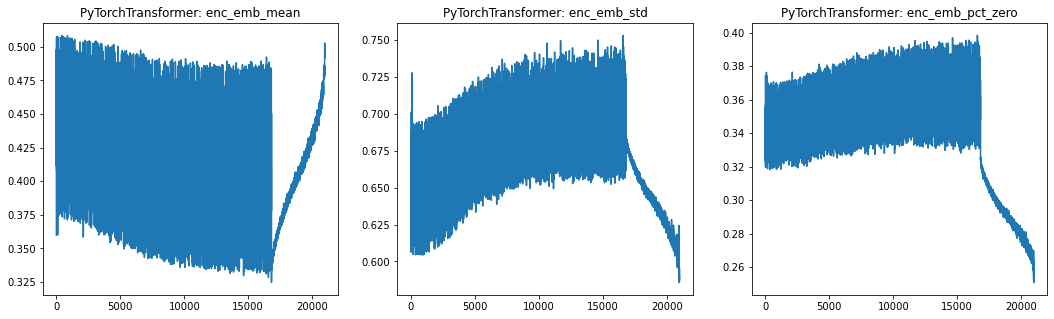

In [ ]:
ds = [enc_dec_dict, pt_dict]
nms = ['BasicTransformer', 'PyTorchTransformer']

for i, d in enumerate(ds):
    _,axs = subplots(1, 3, figsize=(18,5))
    ks = ['enc_emb_mean', 'enc_emb_std', 'enc_emb_pct_zero']
    for o,ax,title in zip(ks,axs,(ks[0], ks[1], ks[2])):
        ax.plot(d[o])
        ax.set_title(f'{nms[i]}: {title}')

### Dec Emb

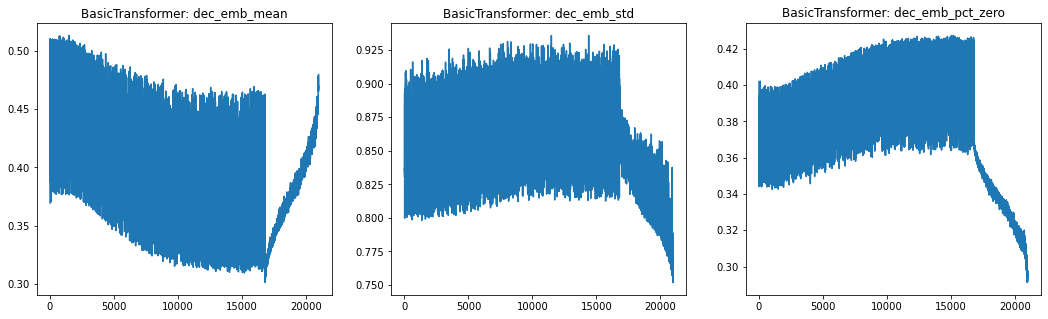

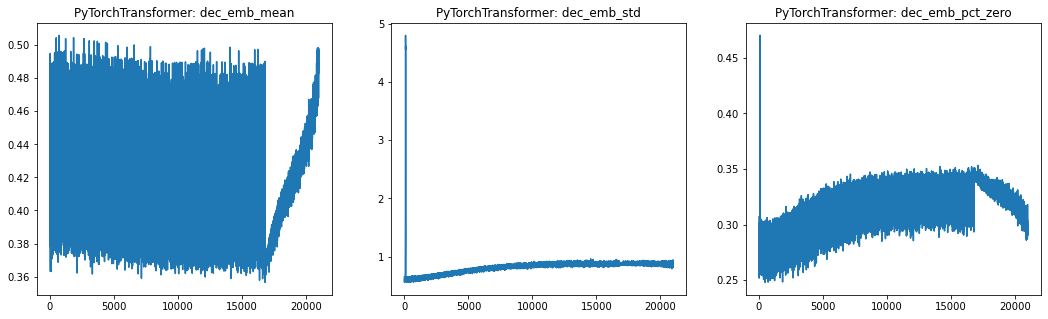

In [ ]:
for i, d in enumerate(ds):
    _,axs = subplots(1, 3, figsize=(18,5))
    ks = ['dec_emb_mean', 'dec_emb_std', 'dec_emb_pct_zero']
    for o,ax,title in zip(ks,axs,(ks[0], ks[1], ks[2])):
        ax.plot(d[o])
        ax.set_title(f'{nms[i]}: {title}')

In [ ]:
enc_dec_dict.keys(), pt_dict.keys()

(dict_keys(['enc_emb_mean', 'enc_emb_std', 'enc_emb_pct_zero', 'dec_emb_mean', 'dec_emb_std', 'dec_emb_pct_zero', 'enc_out_mean', 'enc_out_std', 'enc_out_pct_zero', 'dec_out_mean', 'dec_out_std', 'dec_out_pct_zero', 'fin_out_mean', 'fin_out_std', 'fin_out_pct_zero']),
 dict_keys(['enc_emb_mean', 'enc_emb_std', 'enc_emb_pct_zero', 'dec_emb_mean', 'dec_emb_std', 'dec_emb_pct_zero', 'final_mean', 'final_std', 'final_pct_zero']))

### Dec Out

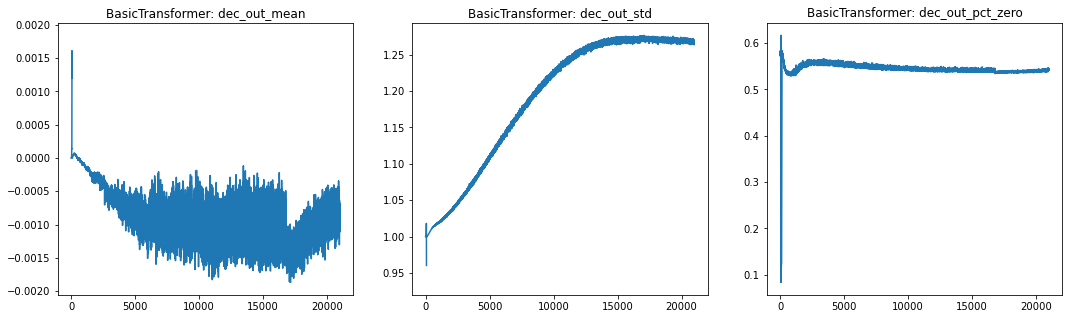

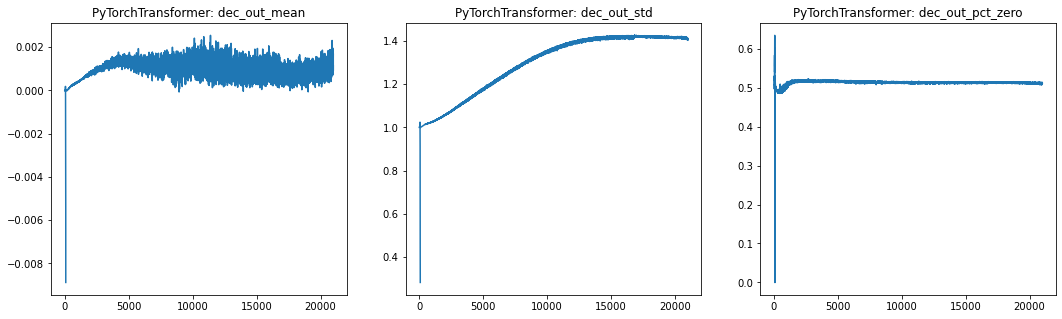

In [ ]:
ds = [enc_dec_dict, pt_dict]
nms = ['BasicTransformer', 'PyTorchTransformer']

for i, d in enumerate(ds):
    _,axs = subplots(1, 3, figsize=(18,5))
    ks = ['dec_out_mean', 'dec_out_std', 'dec_out_pct_zero']
    for o,ax,title in zip(ks,axs,(ks[0], ks[1], ks[2])):
        ax.plot(d[o])
        ax.set_title(f'{nms[i]}: {title}')

### Final

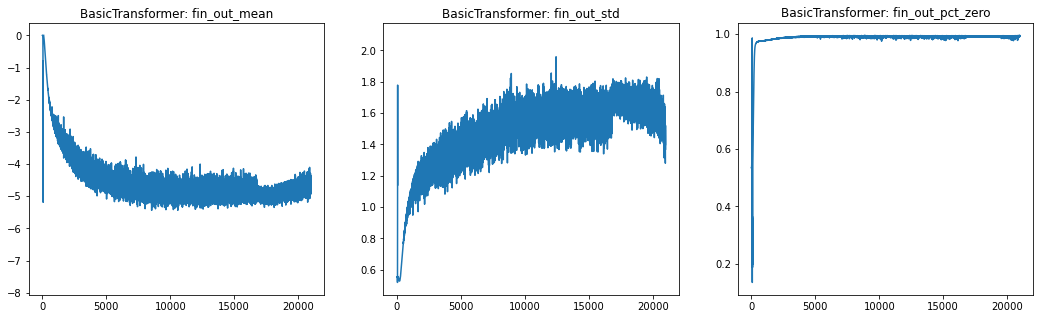

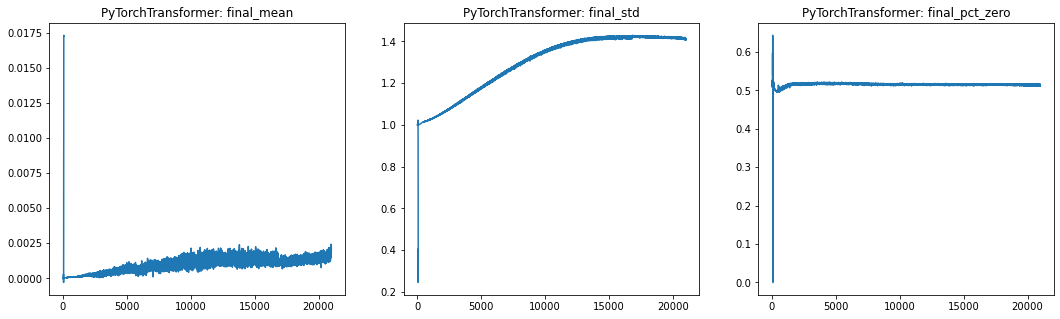

In [ ]:
enc_dec_dict = load_obj('enc_dec_monitor')
pt_dict = load_obj('pt_monitor')

ds = [enc_dec_dict, pt_dict]
nms = ['BasicTransformer', 'PyTorchTransformer']

for i, d in enumerate(ds):
    _,axs = subplots(1, 3, figsize=(18,5))
    if i == 0: ks = ['fin_out_mean', 'fin_out_std', 'fin_out_pct_zero']
    else: ks = ['final_mean', 'final_std', 'final_pct_zero']
    for o,ax,title in zip(ks,axs,(ks[0], ks[1], ks[2])):
        ax.plot(d[o])
        ax.set_title(f'{nms[i]}: {title}')

In [ ]:
enc_dec_dict = load_obj('enc_dec_monitor')

n_stats = len(list(end_dec_dict.keys())) 

for i in range(0, int(n_stats), 3):
    _,axs = subplots(1, 3, figsize=(18,5))
    ks = list(end_dec_dict.keys())[i:i+3]
    for o,ax,title in zip(ks,axs,(ks[0], ks[1], ks[2])):
        ax.plot(end_dec_dict[o])
        ax.set_title(title)

### PyTorch - no Enc causal mask, with dropout

In [ ]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'pt_no_enc_mask'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing pytorch nn.Transformer without encoder causal masking'
CONFIG = {}
TAGS =['pt_encdec','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [ ]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

    
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [ ]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, # d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True, activation='gelu'):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16

        self.final.weight = self.dec_tfmr_emb.embed.weight    # Tie Weights
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation=activation, custom_encoder=None, custom_decoder=None)
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        # Test whether fp16 is being used or not
        if not isinstance(self.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
                          torch.cuda.FloatTensor):
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        #src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        src_mask = None
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                                         src_key_padding_mask=None, tgt_key_padding_mask=None, 
                                         memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        return out.permute(1,0,2)


In [ ]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 

# en_vocab_sz = len(dls.vocab[0])
# ga_vocab_sz = len(dls.vocab[1])
# d_model = 768
n_heads=8 
d_inner=2048  

In [ ]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

pt_model = pt_Transformer(src_vcbsz=en_vocab_sz, trg_vcbsz=ga_vocab_sz, d_model=d_model, d_inner=d_inner)

pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [ ]:
total_params(pt_learn.model)[0]

138170872

SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.3019951581954956)

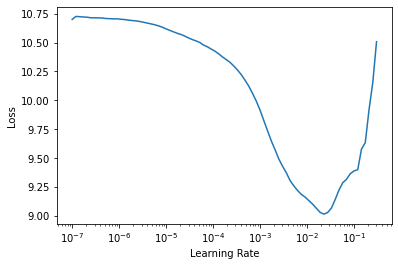

In [ ]:
pt_learn.lr_find()

In [ ]:
pt_learn.fit_one_cycle(3, 1e-4, div=5)  

In [ ]:
pt_learn.recorder.final_record

In [ ]:
pt_learn.recorder.plot_loss()